In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def get_angles(num_qubits,amp_arr):
    out_arr = []
    for k in range(1,num_qubits+1):
        val = 2**(num_qubits - k)
        for j in range(1,val+1):
            #print(j,k)
            new_val = 2**(k-1)
            numerator = 0
            denominator = 0
            
            for l in range(1,new_val + 1):
                pos = (2*j - 1) * (2**(k - 1)) + l
                #print(pos - 1)
                numerator_new = amp_arr[pos - 1]**2
                numerator += numerator_new
            
            for dl in range(1, (2**k)+1):
                pos = (j - 1) * (2**k) + dl
                #print(pos - 1)
                denominator_new = amp_arr[pos - 1]**2
                denominator += denominator_new
                
            final = np.sqrt(numerator) / np.sqrt(denominator + (10**-12))
            final_arcsin = 2 * np.arcsin(final)
            
            #print(j,k,final_arcsin)
            out_arr.append(final_arcsin)
            
    return out_arr
        

In [3]:
get_angles(2,[0.53896774, 0.797503606, 0.27826503, 0.])

[1.9529690593527242, 0.0, 0.5628396364478989]

In [4]:
get_angles(3,[0.44721, 0, 0.7071, 0, 0, 0, 0.44721, 0.31622])

[0.0,
 0.0,
 0.0,
 1.2309438433181639,
 2.013705970177991,
 3.1415890019843085,
 1.159275449106933]

In [5]:
get_angles(4,[0.44721, 0, 0.7071, 0, 0, 0, 0.44721, 0.31622,0.44721, 0, 0.7071, 0, 0, 0, 0.44721, 0.31622])

[0.0,
 0.0,
 0.0,
 1.2309438433181639,
 0.0,
 0.0,
 0.0,
 1.2309438433181639,
 2.013705970177991,
 3.1415890019843085,
 2.013705970177991,
 3.1415890019843085,
 1.159275449106933,
 1.159275449106933,
 1.5707963267943965]

In [6]:
def get_binary(x,max_pad):
    if x == 0: 
        arr = []
        for u in range(max_pad):
            arr.append(0)
        return arr
    bit = []
    new_arr = []
    while x:
        bit.append(x % 2)
        x >>= 1
        
    for u in range(max_pad - len(bit)):
        new_arr.append(0)
        
    new_arr.extend(bit[::-1])
    return new_arr

In [7]:
arr = get_binary(6,3)
print(arr)

[1, 1, 0]


In [8]:
from qiskit.circuit.library.standard_gates import RYGate
from qiskit.circuit import Parameter
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit,QuantumRegister

def generate_circuit(num_qubits,angles):
    qr=QuantumRegister(num_qubits)
    circ=QuantumCircuit(qr) 
    
    count = -1
    for i in range(0,num_qubits):
        control_qubits = []
        for u in range(0,i):
            control_qubits.append(u)
        
        val = int(2**i)
        for j in range(0,val):
            bin_arr = get_binary(j,i)
            if(i == 0):
                circ.ry(angles[count],i)
                count -= 1
                
            elif(i == 1):
                for x in range(len(bin_arr)):
                    if(bin_arr[x] == 1):
                        circ.x(x)
                        
                circ.cry(angles[count],0,i)
                count -= 1
                
                for x in range(len(bin_arr)):
                    if(bin_arr[x] == 1):
                        circ.x(x)
            
            else:
                for x in range(len(bin_arr)):
                    if(bin_arr[x] == 1):
                        circ.x(x)
                        
                circ.mcry(angles[count],control_qubits,i,q_ancillae=None)
                count -= 1
                
                for x in range(len(bin_arr)):
                    if(bin_arr[x] == 1):
                        circ.x(x)
                
        
        circ.barrier()
        
    circ.measure_all()
    return circ

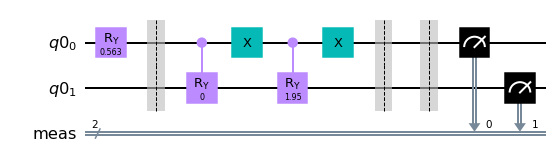

In [9]:
circ = generate_circuit(2,get_angles(2,[0.53896774, 0.797503606, 0.27826503, 0.]))
circ.draw(output='mpl')

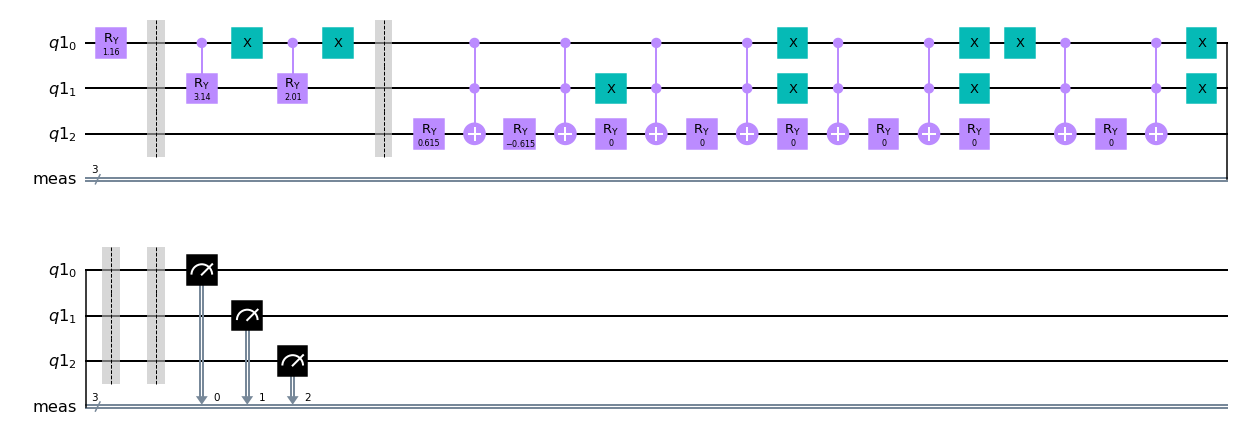

In [10]:
circ = generate_circuit(3,get_angles(3,[0.44721, 0, 0.7071, 0, 0, 0, 0.44721, 0.31622]))
circ.draw(output='mpl')

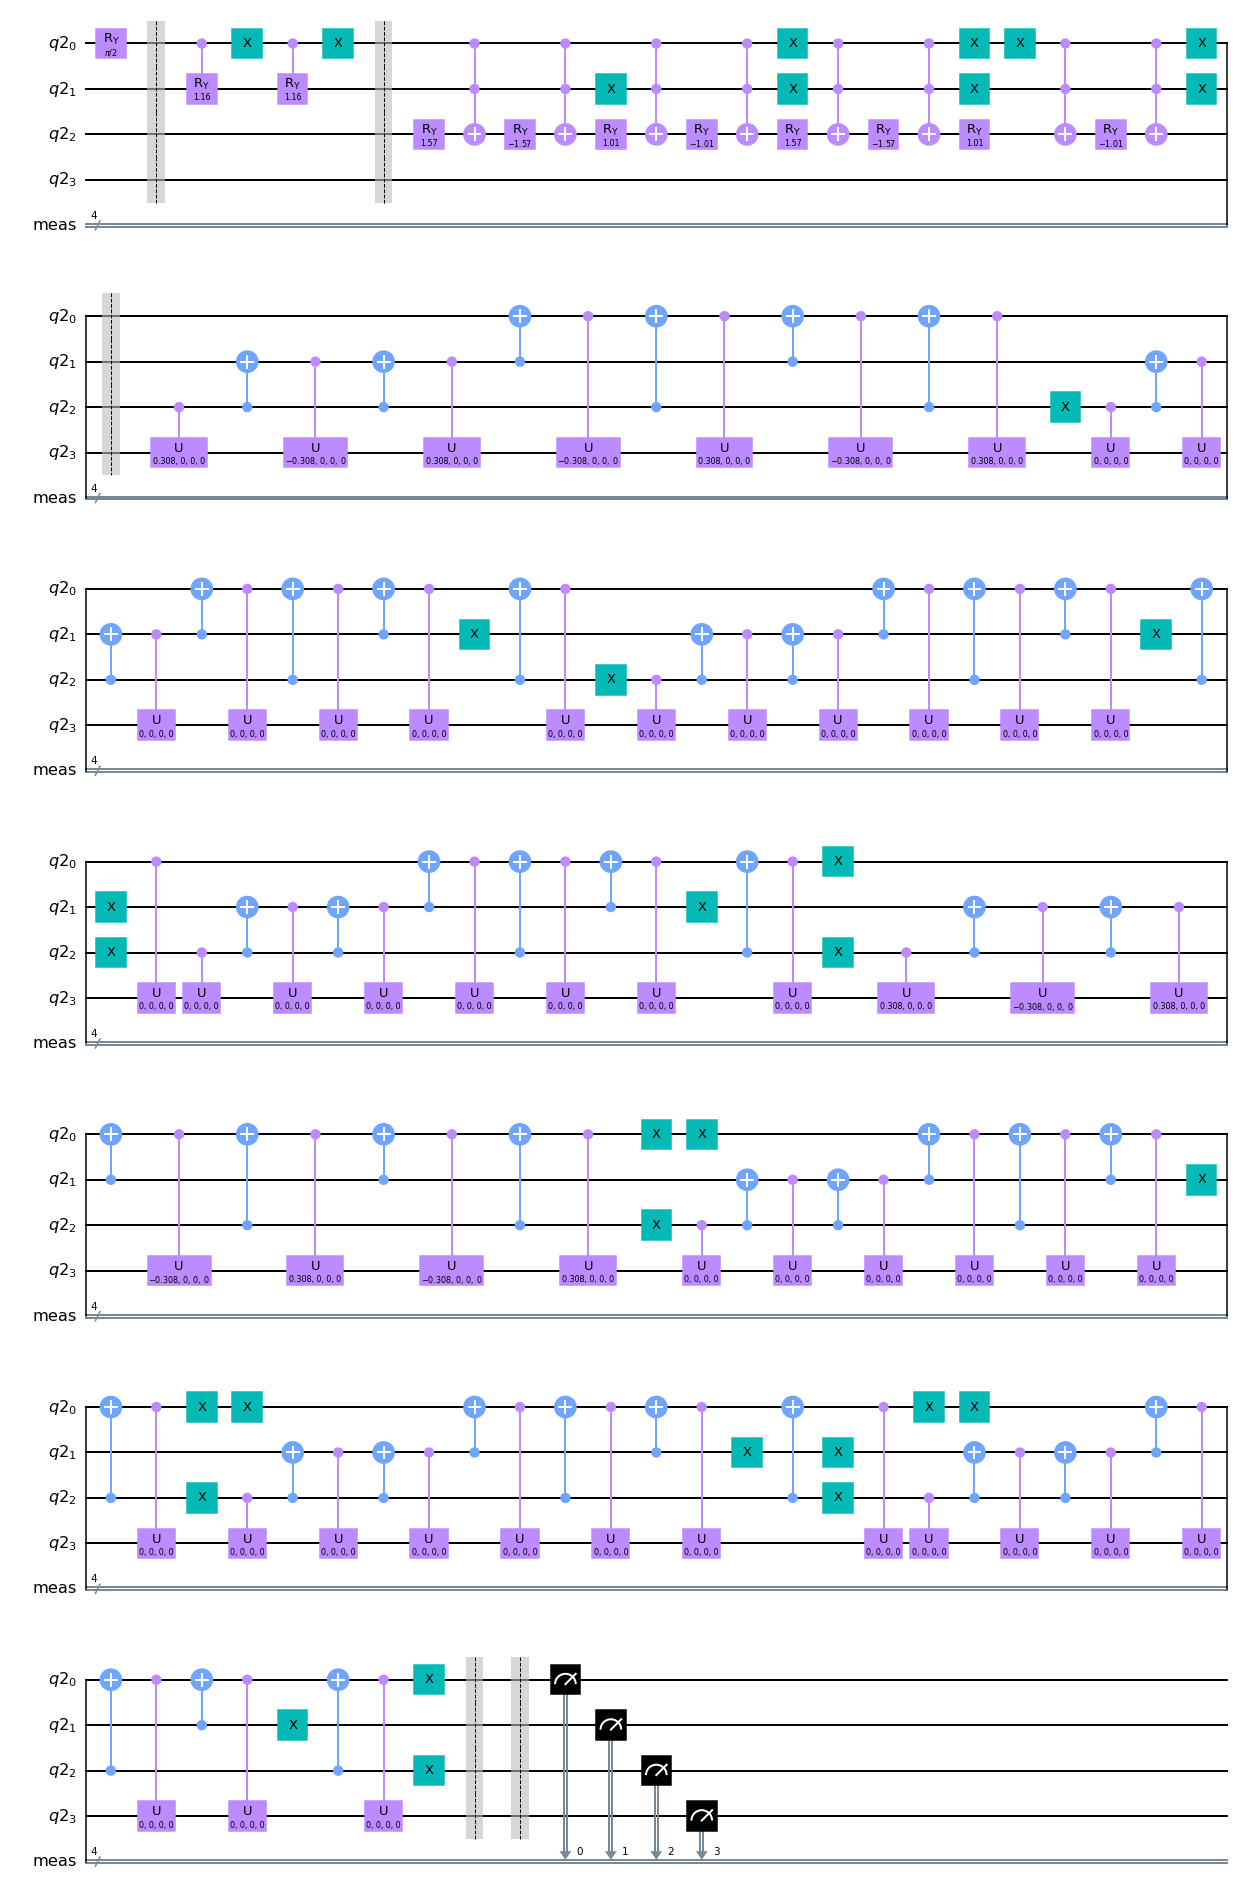

In [11]:
circ = generate_circuit(4,get_angles(4,[0.44721, 0, 0.7071, 0, 0, 0, 0.44721, 0.31622,0.44721, 0, 0.7071, 0, 0, 0, 0.44721, 0.31622]))
circ.draw(output='mpl')

In [12]:
def testing(num_qubits,amp_sqrt):
    
    circ = generate_circuit(num_qubits,get_angles(num_qubits,amp_sqrt))
    circ.draw(output='mpl')
    
    backend_sim = Aer.get_backend('qasm_simulator')

    # Execute the circuit on the qasm simulator.
    # We've set the number of repeats of the circuit
    # to be 1024, which is the default.
    job_sim = backend_sim.run(transpile(circ, backend_sim), shots=8192)

    # Grab the results from the job.
    result_sim = job_sim.result()
    counts = result_sim.get_counts(circ)
    #print(counts)
    counts_new = {}
    for x in counts:
        counts_new[x] = (counts[x]/8192)

    print(counts_new)

In [13]:
# Amplitudes
# 000 -> 0.2
# 001 -> 0 
# 010 -> 0.5
# 011 -> 0
# 100 -> 0
# 101 -> 0
# 110 -> 0.2
# 111 -> 0.1
# We pass the Sqrt of these to get the origina amplitudes
testing(3, [0.44721, 0, 0.7071, 0, 0, 0, 0.44721, 0.31622])

{'111': 0.0980224609375, '011': 0.1988525390625, '010': 0.5062255859375, '000': 0.1968994140625}


In [14]:
# Amplitudes
#00 -> 0.2783203125
#01 -> 0.0791015625
#10 -> 0.642578125
#11 -> 0
# We pass the Sqrt of these to get the original amplitudes
testing(2, [0.53896774, 0.797503606, 0.27826503, 0.])

{'01': 0.0784912109375, '10': 0.63671875, '00': 0.2847900390625}
